# Regression logistique avec les reseaux de neurones et Tensorflow

Le but de ce travail est de créer un modèle de reseaux de neurones avec Tensorflow pour reconnaitre si une image est celle d'un chat ou pas.

Let's Start!!

**Instructions:**
- N'utilisez pas de boucles (for/while) dans votre code, à moins que les instructions ne vous le demandent explicitement.

**Vous allez apprendre à:**
- Construire l'architecture générale d'un algorithme d'apprentissage, comprenant :
     - Initialisation des paramètres
     - Calcul de la fonction de coût et de son gradient
     - Utilisation d'un algorithme d'optimisation (descente de gradient)
- Rassemblez les trois fonctions ci-dessus dans une fonction de modèle principale, dans le bon ordre.
- Testez avec votre propre image

## 1 - Packages ##

Tout d'abord, exécutons la cellule ci-dessous pour importer tous les packages dont vous aurez besoin pendant cette mission.
- [numpy](www.numpy.org) est le package fondamental pour le calcul scientifique avec Python.
- [h5py](http://www.h5py.org) est un package courant pour interagir avec un ensemble de données stocké dans un fichier H5.
- [matplotlib](http://matplotlib.org) est une bibliothèque célèbre pour tracer des graphiques en Python.
- [PIL](http://www.pythonware.com/products/pil/) et [scipy](https://www.scipy.org/) sont utilisés ici pour tester votre modèle avec votre propre photo à la fin .

- Installer la version 1.15 de tensorflow avec la commande suivante: pip install tensorflow==1.15

- Installer la version 3.4.2 de open cv avec les lignes de commande suivante: pip install opencv-python==3.4.2.17, dès que c'est terminé exécuter aussi pip install opencv-contrib-python==3.4.2.17 

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import math
from math import *
import scipy


import tensorflow as tf
from tensorflow.python.framework import ops

from PIL import Image
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

## 2 - Aperçu de l'ensemble de problèmes ##

**Énoncé du problème** : vous recevez un ensemble de données ("data.h5") contenant :
     - un ensemble d'apprentissage d'images m_train étiquetées comme chat (y=1) ou non-chat (y=0)
     - un ensemble de test d'images m_test étiquetées comme chat ou non-chat
     - chaque image est de forme (num_px, num_px, 3) où 3 est pour les 3 canaux (RVB). Ainsi, chaque image est carrée (hauteur = num_px) et (largeur = num_px).

Vous allez créer un algorithme de reconnaissance d'image simple qui peut correctement classer les images comme chat ou non-chat.

Familiarisons-nous avec l'ensemble de données. Chargez les données en exécutant le code suivant.

In [99]:
# Chargement des données (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Nous avons ajouté "_orig" à la fin des jeux de données d'images (train et test) car nous allons les prétraiter. Après le prétraitement, nous nous retrouverons avec train_set_x et test_set_x (les étiquettes train_set_y et test_set_y n'ont besoin d'aucun prétraitement).

Chaque ligne de votre train_set_x_orig et test_set_x_orig est un tableau représentant une image. Vous pouvez visualiser un exemple en exécutant le code suivant. N'hésitez pas également à modifier la valeur `index` et à réexécuter pour voir d'autres images.

y = [0], it's a 'non-cat' picture.


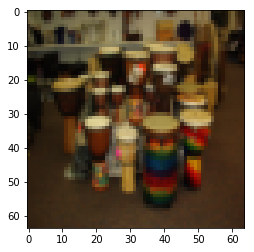

In [100]:
# Exemple d'exemple

index = 5
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

De nombreux bogues logiciels dans l'apprentissage en profondeur proviennent d'avoir des dimensions matrice/vecteur qui ne correspondent pas. Si vous pouvez garder les dimensions de votre matrice/vecteur droites, vous contribuerez grandement à éliminer de nombreux bogues.

**Exercice :** Trouvez les valeurs pour :
     - m_train (nombre d'exemples de formation)
     - m_test (nombre d'exemples de test)
     - num_px (= hauteur = largeur d'une image d'entraînement)
N'oubliez pas que `train_set_x_orig` est un tableau numpy de forme (m_train, num_px, num_px, 3). Par exemple, vous pouvez accéder à `m_train` en écrivant `train_set_x_orig.shape[0]`.

In [101]:

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[2]


print ("Nombre d'exemples de formation: m_train = " + str(m_train))
print ("Nombre d'exemples de test: m_test = " + str(m_test))
print ("Hauteur/Largeur de chaque image: num_px = " + str(num_px))
print ("Chaque image est de taille: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("taille train_set_x : " + str(train_set_x_orig.shape))
print ("taille train_set_y : " + str(train_set_y.shape))
print ("taille test_set_x : " + str(test_set_x_orig.shape))
print ("taille test_set_y : " + str(test_set_y.shape))

Nombre d'exemples de formation: m_train = 209
Nombre d'exemples de test: m_test = 50
Hauteur/Largeur de chaque image: num_px = 64
Chaque image est de taille: (64, 64, 3)
taille train_set_x : (209, 64, 64, 3)
taille train_set_y : (1, 209)
taille test_set_x : (50, 64, 64, 3)
taille test_set_y : (1, 50)


Pour plus de commodité, vous devez maintenant remodeler les images de forme (num_px, num_px, 3) dans un tableau numpy de forme (num_px $*$ num_px $*$ 3, 1). Après cela, notre ensemble de données d'entraînement (et de test) est un tableau numpy où chaque colonne représente une image aplatie. Il devrait y avoir des colonnes m_train (respectivement m_test).

**Exercice :** Remodelez les ensembles de données d'entraînement et de test afin que les images de taille (num_px, num_px, 3) soient aplaties en vecteurs de forme uniques (num\_px $*$ num\_px $*$ 3, 1).

Une astuce pour aplatir une matrice X de forme (a,b,c,d) en une matrice X_flatten de forme (b$*$c$*$d, a) est d'utiliser :
```python
X_flatten = X.reshape(X.shape[0], -1).T # X.T est la transposée de X
```
En plus de cela, vous convertirez chaque étiquette en un vecteur unique, comme le montre la figure 1. Exécutez la cellule ci-dessous pour le faire.

In [102]:
# Flatten the training and test images
X_train_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
X_test_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(train_set_y, 2)
Y_test = convert_to_one_hot(test_set_y, 2)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 209
number of test examples = 50
X_train shape: (12288, 209)
Y_train shape: (2, 209)
X_test shape: (12288, 50)
Y_test shape: (2, 50)


**Notez** que 12288 vient de $64 \times 64 \times 3$. Chaque image est carrée, 64 par 64 pixels, et 3 est pour les couleurs RVB. Veuillez vous assurer que toutes ces formes ont un sens pour vous avant de continuer.

Pour représenter des images en couleur, les canaux rouge, vert et bleu (RVB) doivent être spécifiés pour chaque pixel, et donc la valeur du pixel est en fait un vecteur de trois nombres allant de 0 à 255.

Une étape de prétraitement courante dans l'apprentissage automatique consiste à centrer et à normaliser votre ensemble de données, ce qui signifie que vous soustrayez la moyenne de l'ensemble du tableau numpy de chaque exemple, puis divisez chaque exemple par l'écart type de l'ensemble du tableau numpy. Mais pour les ensembles de données d'images, il est plus simple et plus pratique et fonctionne presque aussi bien de simplement diviser chaque ligne de l'ensemble de données par 255 (la valeur maximale d'un canal de pixel).

<!-- Lors de l'apprentissage de votre modèle, vous allez multiplier les poids et ajouter des biais à certaines entrées initiales afin d'observer les activations des neurones. Ensuite, vous effectuez une rétropropagation avec les dégradés pour entraîner le modèle. Mais, il est extrêmement important que chaque fonctionnalité ait une plage similaire afin que nos dégradés n'explosent pas. Vous verrez cela plus en détail plus tard dans les conférences. !-->

Standardisons notre jeu de données.

In [103]:
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

<font color='bleu'>
**Ce que vous devez retenir :**

Les étapes courantes du prétraitement d'un nouvel ensemble de données sont :
- Déterminer les dimensions et les formes du problème (m_train, m_test, num_px, ...)
- Remodeler les jeux de données de telle sorte que chaque exemple soit désormais un vecteur de taille (num_px \* num_px \* 3, 1)
- "Standardiser" les données

### 2.1 - Créer des espaces réservés

Votre première tâche consiste à créer des espaces réservés pour « X » et « Y ». Cela vous permettra de transmettre plus tard vos données d'entraînement lorsque vous exécutez votre session.

**Exercice :** implémentez la fonction ci-dessous pour créer les espaces réservés dans tensorflow.

In [104]:
#  FONCTION: create_placeholders

def create_placeholders(n_x, n_y):
    """
    Crée les espaces réservés pour la session tensorflow.
    
    Arguments:
     n_x -- scalaire, taille d'un vecteur d'image (num_px * num_px = 64 * 64 * 3 = 12288)
     n_y -- scalaire, nombre de classes (de 0 à 1, donc -> 2)
    
     Retour:
     X -- espace réservé pour l'entrée de données, de forme [n_x, None] et de type "tf.float32"
     Y -- espace réservé pour les étiquettes d'entrée, de forme [n_y, None] et de type "tf.float32"
    
     Conseils:
     - Vous utiliserez None car cela nous permet d'être flexibles sur le nombre d'exemples que vous utiliserez pour les espaces réservés.
       En fait, le nombre d'exemples pendant le test/train est différent.
     """

   
    X = tf.placeholder(tf.float32, shape = [n_x, None], name = "X")
    Y = tf.placeholder(tf.float32, shape = [n_y, None], name = "Y")
   
    
    return X, Y

In [105]:
X, Y = create_placeholders(12288, 2)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X_1:0", shape=(12288, ?), dtype=float32)
Y = Tensor("Y_1:0", shape=(2, ?), dtype=float32)


In [106]:
import tensorflow
print(tensorflow.__version__)

1.15.0


In [107]:
# Changer la valeur de x dans le feed_dict
sess = tf.Session()
x = tf.placeholder(tf.int64, name = 'x')
print(sess.run(2 * x, feed_dict = {x: 3}))
sess.close()

6


## 3 - Architecture générale de l'algorithme d'apprentissage ##

Il est temps de concevoir un algorithme simple pour distinguer les images de chat des images de non-chat.

Vous allez construire une régression logistique, en utilisant un état d'esprit de réseau neuronal. La figure suivante explique pourquoi **La régression logistique est en fait un réseau de neurones très simple !**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Expression mathématique de l'algorithme** :

Pour un exemple $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

Le coût est ensuite calculé en additionnant tous les exemples de formation :
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Étapes clés** :
Dans cet exercice, vous effectuerez les étapes suivantes :
     - Initialiser les paramètres du modèle
     - Apprendre les paramètres du modèle en minimisant le coût
     - Utiliser les paramètres appris pour faire des prédictions (sur l'ensemble de test)
     - Analyser les résultats et conclure

## 4 - Construire les parties de notre algorithme ##

Les principales étapes de la construction d'un réseau de neurones sont :
1. Définir la structure du modèle (comme le nombre d'entités en entrée)
2. Initialiser les paramètres du modèle
3. Boucle :
     - Calculer la perte de courant (propagation directe)
     - Calculer le gradient de courant (propagation vers l'arrière)
     - Mettre à jour les paramètres (descente de gradient)

Vous construisez souvent 1-3 séparément et les intégrez dans une fonction que nous appelons `model()`.

### 4.1 - Calcul du sigmoïde

Tensorflow offre une variété de fonctions de réseau de neurones couramment utilisées, telles que « tf.sigmoid » et « tf.softmax ». Pour cet exercice, calculons la fonction sigmoïde d'une entrée.

Vous ferez cet exercice en utilisant une variable d'espace réservé « x ». Lors de l'exécution de la session, vous devez utiliser le dictionnaire de flux pour transmettre l'entrée « z ». Dans cet exercice, vous devrez (i) créer un espace réservé « x », (ii) définir les opérations nécessaires pour calculer le sigmoïde à l'aide de « tf.sigmoïd », puis (iii) exécuter la session.

** Exercice ** : Implémentez la fonction sigmoïde ci-dessous. Vous devez utiliser les éléments suivants :

- `tf.placeholder(tf.float32, name = "...")`
- `tf.sigmoïd(...)`
- `sess.run(..., feed_dict = {x:z})`


Notez qu'il existe deux manières typiques de créer et d'utiliser des sessions dans tensorflow :

**Méthode 1 :**
```python
sess = tf.Session()
# Exécutez l'initialisation des variables (si nécessaire), exécutez les opérations
résultat = sess.run(..., feed_dict = {...})
sess.close() # Ferme la session
```
**Méthode 2:**
```python
with tf.Session() as session :
    # lance l'initialisation des variables (si besoin), lance les opérations
    résultat = sess.run(..., feed_dict = {...})
    # Ceci s'occupe de clôturer la session pour vous :)
```

In [108]:
# FONCTION: sigmoid

def sigmoid(z):
    """
    Calculer la sigmoide de z

    Arguments:
    z -- Un scalaire ou un tableau numpy de n'importe quelle taille.

    Return:
    s -- sigmoid(z)
    """

   
     # Créez un espace réservé pour x. Nommez-le « x ».
    x = tf.placeholder(tf.float32, name = "x")

     # calcule sigmoïde(x)
    y = tf.sigmoid(x)

     # Créez une session et exécutez-la. Veuillez utiliser la méthode 2 expliquée ci-dessus.
     # Vous devez utiliser un feed_dict pour passer la valeur de z à x.
    with tf.Session() as sess:
         # Exécutez la session et appelez la sortie "résultat"
        result = sess.run(y, feed_dict = {x:z})

    
    
    return result

In [109]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(12) = " + str(sigmoid(12)))

sigmoid(0) = 0.5
sigmoid(12) = 0.9999938



### 4.2 - Initialisation des paramètres

Votre deuxième tâche consiste à initialiser les paramètres dans tensorflow.

**Exercice :** Implémentez la fonction ci-dessous pour initialiser les paramètres dans tensorflow. Vous allez utiliser l'initialisation Xavier pour les poids et l'initialisation zéro pour les biais. Les formes sont données ci-dessous. A titre d'exemple, pour vous aider, pour W1 et b1, vous pouvez utiliser :

```python
W1 = tf.get_variable("W1", [25,12288], initialiseur = tf.contrib.layers.xavier_initializer(seed = 1))
b1 = tf.get_variable("b1", [25,1], initialiseur = tf.zeros_initializer())
```
Veuillez utiliser `seed = 1` pour vous assurer que vos résultats correspondent aux nôtres.

In [110]:
# FONCTION: initialize_parameters

def initialize_parameters():
    """
     Initialisez les paramètres pour construire un réseau de neurones avec tensorflow. Les formes sont :
                         W1 : [25, 12288]
                         b1 : [25, 1]
                         W2 : [12, 25]
                         b2 : [12, 1]
                         W3 : [2, 12]
                         b3 : [2, 1]
    
     Return:
     paramètres -- un dictionnaire de tenseurs contenant W1, b1, W2, b2, W3, b3
     """
    
    tf1.set_random_seed(1)                   # pour que vos nombres "aléatoires" correspondent aux nôtres
        
    
    W1 = tf1.get_variable('W1', [25,12288], initializer = tf2.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf1.get_variable('b1', [25,1], initializer = tf1.zeros_initializer())
    W2 = tf1.get_variable('W2', [12,25], initializer = tf2.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf1.get_variable('b2', [12,1], initializer = tf1.zeros_initializer())
    W3 = tf1.get_variable('W3', [2,12], initializer = tf2.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf1.get_variable('b3', [2,1], initializer = tf1.zeros_initializer())
  

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [111]:
tf1.reset_default_graph()
with tf1.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))

W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>


### 4.3 - Propagation vers l'avant dans le tensorflow

Vous allez maintenant implémenter le module de propagation vers l'avant dans tensorflow. La fonction prendra un dictionnaire de paramètres et terminera la passe avant. Les fonctions que vous utiliserez sont :

- `tf.add(...,...)` pour faire un ajout
- `tf.matmul(...,...)` pour faire une multiplication matricielle
- `tf.nn.relu(...)` pour appliquer l'activation ReLU

**Question :** implémentez la transmission directe du réseau de neurones. Nous avons commenté pour vous les équivalents de numpy afin que vous puissiez comparer l'implémentation de tensorflow à numpy. Il est important de noter que la propagation vers l'avant s'arrête à "z3". La raison en est que dans le flux tensoriel, la dernière sortie de couche linéaire est donnée en entrée à la fonction calculant la perte. Par conséquent, vous n'avez pas besoin de « a3 » !

In [112]:
## FONCTION: forward_propagation

def forward_propagation(X, parameters):
    """
     Implémente la propagation vers l'avant pour le modèle : LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    
     Arguments:
     X -- espace réservé pour l'ensemble de données d'entrée, de forme (taille d'entrée, nombre d'exemples)
     paramètres -- dictionnaire python contenant vos paramètres "W1", "b1", "W2", "b2", "W3", "b3"
                   les formes sont données dans initialize_parameters

     Retour:
     Z3 -- la sortie de la dernière unité LINEAR
     """
    
    # Récupérer les paramètres du dictionnaire "paramètres"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
                                                                              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X),b1)                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                              # Z2 = np.dot(W2, A1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                               # Z3 = np.dot(W3, A2) + b3
   
    
    return Z3

In [113]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 2)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(2, ?), dtype=float32)


### 4.4 Calculer le coût

Comme vu précédemment, il est très facile de calculer le coût en utilisant :
```python
tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ..., labels = ...))
```
**Question** : Implémentez la fonction de coût ci-dessous.
- Il est important de savoir que les entrées "`logits`" et "`labels`" de `tf.nn.softmax_cross_entropy_with_logits` sont censées être de forme (nombre d'exemples, num_classes). Nous avons donc transposé pour vous Z3 et Y.
- En outre, `tf.reduce_mean` fait essentiellement la sommation sur les exemples.

In [114]:
# FONCTION: compute_cost 

def compute_cost(Z3, Y):
    """
     Calcule le coût
    
     Arguments:
     Z3 -- sortie de propagation vers l'avant (sortie de la dernière unité LINÉAIRE), de forme (6, nombre d'exemples)
     Y -- "true" étiquettes vecteur espace réservé, même forme que Z3
    
     Return:
     cost - Tenseur de la fonction de coût
     """
    
   # pour s'adapter à l'exigence de tensorflow pour tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
   
    
    return cost

In [115]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


### 2.5 - Propagation vers l'arrière et mises à jour des paramètres

C'est là que vous devenez reconnaissant envers les frameworks de programmation. Toute la rétropropagation et la mise à jour des paramètres sont prises en charge en 1 ligne de code. Il est très facile d'intégrer cette ligne dans le modèle.

Après avoir calculé la fonction de coût. Vous allez créer un objet "`optimiseur`". Vous devez appeler cet objet avec le coût lors de l'exécution de tf.session. Lorsqu'il est appelé, il effectuera une optimisation sur le coût donné avec la méthode et le taux d'apprentissage choisis.

Par exemple, pour la descente de gradient, l'optimiseur serait :
```python
optimiseur = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(coût)
```

Pour faire l'optimisation, vous feriez:
```python
_ , c = sess.run([optimiseur, coût], feed_dict={X : minibatch_X, Y : minibatch_Y})
```

Cela calcule la rétropropagation en passant par le graphe tensorflow dans l'ordre inverse. Du coût aux intrants.

**Remarque** Lors du codage, nous utilisons souvent `_` comme variable "jetable" pour stocker des valeurs que nous n'aurons pas besoin d'utiliser plus tard. Ici, `_` prend la valeur évaluée de `optimiseur`, dont nous n'avons pas besoin (et `c` prend la valeur de la variable `coût`).

### 2.6 - Construction du modèle

Maintenant, vous allez tout rassembler !

**Exercice :** Mettre en œuvre le modèle. Vous appellerez les fonctions que vous aviez précédemment implémentées.

In [116]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # vos caractéristiques d'entrainement
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # vos labels d'entrainement

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # vos caractéristiques de test
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # vos labels de test

    classes = np.array(test_dataset["list_classes"][:]) # la liste de vos classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # nombre d'exemples d'entrainement
    mini_batches = []
    np.random.seed(seed)
    
    # Etape 1: Mélanger (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Etape 2: Partition (shuffled_X, shuffled_Y). Moins le cas final.
    num_complete_minibatches = math.floor(m/mini_batch_size) # nombre de mini lots de taille mini_batch_size dans votre partitionnement
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Gestion du cas final (dernier mini-lot < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [12288, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Récupérer les paramètres du dictionnaire "paramètres" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3
    


In [118]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    ops.reset_default_graph()                         # pouvoir réexécuter le modèle sans écraser les variables tf
    tf.set_random_seed(1)                             # pour garder des résultats cohérents
    seed = 3                                          # pour garder des résultats cohérents
    (n_x, m) = X_train.shape                          # (n_x: taille d'entrée, m : nombre d'exemples d'entrainement)
    n_y = Y_train.shape[0]                            # n_y : taille de sortie
    costs = []                                        # Pour suivre le coût
    
    # Créer des espaces réservés de forme (n_x, n_y)
    
    X, Y = create_placeholders(n_x, n_y)
   
    # Initialiser les paramètres
    
    parameters = initialize_parameters()
   
    
    # Propagation vers l'avant:Construire la propagation vers l'avant dans le graphe tensorflow
  
    Z3 = forward_propagation(X, parameters)
  
    
    # fonction Coût: Ajouter la fonction coût dans le graphe tensorflow 
   
    cost = compute_cost(Z3, Y)
  
    
    # Propagation vers l'arrière: Définir la fonction optimizer de tensorflow. Utiliser AdamOptimizer.
  
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
  
    
    # Initializer toutes les variables
    init = tf.global_variables_initializer()

    # Démarrer la session pour calculer le graphe tensorflow
    with tf.Session() as sess:
        
        # Exécuter l'initialisation
        sess.run(init)
        
        # Faire la boucle d'entraînement
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Définit un coût lié à une époque
            num_minibatches = int(m / minibatch_size) # nombre de minilots de taille minibatch_size dans la rame
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Sélectionnez un mini-lot
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT : La ligne qui exécute le graphique sur un mini-lot.
                 # Exécutez la session pour exécuter "l'optimiseur" et le "coût", le feeddict doit contenir un mini-lot pour (X,Y).
               
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict = {X :minibatch_X, Y: minibatch_Y})
               
                
                epoch_cost += minibatch_cost / minibatch_size

            # Afficher le coût à chaque époque
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # Afficher le coût
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Sauvegardons les paramètres dans une variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculer les bonnes prédictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculer la précision sur l'ensemble de test
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 0.153379
Cost after epoch 100: 0.036149
Cost after epoch 200: 0.006013
Cost after epoch 300: 0.001824
Cost after epoch 400: 0.000765
Cost after epoch 500: 0.000402
Cost after epoch 600: 0.000209
Cost after epoch 700: 0.000117
Cost after epoch 800: 0.000070
Cost after epoch 900: 0.000044
Cost after epoch 1000: 0.000027
Cost after epoch 1100: 0.000018
Cost after epoch 1200: 0.000011
Cost after epoch 1300: 0.000007
Cost after epoch 1400: 0.000005


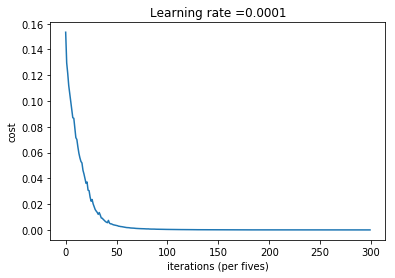

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.76


In [119]:
import math
parameters = model(X_train, Y_train, X_test, Y_test)

**Commentaire** : La précision de l'entraînement est proche de 100 %. Il s'agit d'un bon contrôle d'intégrité : votre modèle fonctionne et a une capacité suffisamment élevée pour s'adapter aux données d'entraînement. La précision du test est de 76%. Ce n'est en fait pas mal pour ce modèle simple, compte tenu du petit ensemble de données que nous avons utilisé et du fait que la régression logistique est un classificateur linéaire. Mais pas de soucis, vous construirez un classificateur encore meilleur la semaine prochaine !



### IMPORTATION DES LIBRAIRIES

In [120]:
import imageio
import cv2

In [121]:
cv2.__version__

'3.4.2'

### TEST AVEC DES IMAGES TELECHARGEES SUR INTERNET

## 3 - Testez avec votre propre image  ##

Félicitations vous êtes presque à la fin. Vous pouvez utiliser votre propre image et voir le résultat de votre modèle. Pour faire ça:
     1. Cliquez sur « Fichier » dans la barre supérieure de ce carnet, puis cliquez sur « Ouvrir » pour accéder à votre dossier d'images.
     2. Ajoutez votre image dans le répertoire de ce Jupyter Notebook, dans le dossier "images"
     3. Changez le nom de votre image dans le code suivant
     4. Exécutez le code et vérifiez si l'algorithme est correct (1 = chat, 0 = non-chat) !

Your algorithm predicts: y = 0


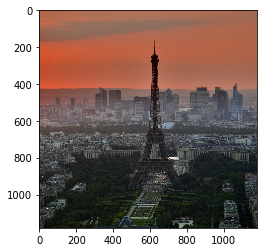

In [122]:


my_image = "la_defense.jpg"


# We preprocess your image to fit your algorithm.
fname = "images/" + my_image
image = np.array(imageio.imread(fname))
image = image/255.
my_image = cv2.resize(image, (64,64)).reshape((1, 64*64*3)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))

### TEST AVEC DES IMAGES PROVENANT DE L'ENSEMBLE DE TEST

y = 1.0, Your algorithm predicts: y = 1


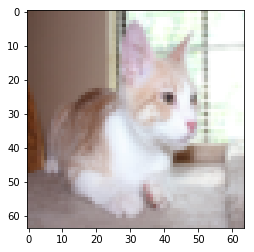

In [123]:
# Example of a picture that was wrongly classified.
index=4
plt.imshow(X_test[:,index].reshape((num_px, num_px, 3)))
image =X_test[:,index].reshape((num_px, num_px, 3))/255.
image = cv2.resize(image, (64,64)).reshape((1, 64*64*3)).T
print ("y = " + str(Y_test[1,index]) + ", Your algorithm predicts: y = " + str(np.squeeze(predict(image, parameters))))

## Dans cette partie, nous testerons notre modèle en utilisant une interface graphique créée avec Tkinter

**1) Importation des librairies ( pour importer une librairie on écrit import "nom de la librairie" as "diminutif"; pour importer un package spécifique à une librairie, on écrit from "nom de la librairie" import "nom du package")**
- Importer la librairie tkinter comme tk : tkinter est l'une des librairies de python pour concevoir les interfaces graphiques.
Exemple: import tkinter as tk
- Importer le package filedialog de la librairie tkinter
- Importer tous les packages de tkinter avec l'élément *
- Importer les packages ImageTk et Image de la librairie PIL

**Indication**: L'espace vide laissé avant le symbole "#" vous indique que vous devez ecrire un code avant ce symbole

In [ ]:
import tkinter as tk                            # Importation de tkinter
from tkinter import filedialog                            # Importation du package filedialog de la librairie tkinter
from tkinter import *                             # Importation de tous les packages de tkinter
from PIL import ImageTk, Image                             # Importation des packages ImageTk et Image de la librairie PIL
import numpy                             # Importation de numpy

### Exécuter la cellule suivante pour créer un dictionnaire

In [87]:
#dictionnaire pour labelliser les classes de nos images
classes = { 0:"Ce n'est pas un chat",
            1:"C'est un chat" 
 }


### Exécuter la cellule suivante pour initialiser Tkinter

In [88]:
#initialise GUI
top=tk.Tk()
top.geometry('800x600')
top.title('Classification des images')
top.configure(background='#CDCDCD')

label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)

### Exécuter la cellule suivante pour créer la fonction classify qui appelera notre modèle pour la prédiction

In [89]:
def classify(file_path):
    global label_packed
    image = Image.open(file_path)
    image = image.resize((64, 64))
    image = numpy.expand_dims(image, axis=0)
    image = numpy.array(image)
    image = image.reshape((1, 64*64*3)).T
    pred = int(np.squeeze(predict(image, parameters)))
    sign = classes[pred]
    print(sign)
    label.configure(foreground='#011638', text=sign) 


### La fonction suivante permet un bouton "Classifier l'image qui appelera notre fonction "classify" que nous avons créer plus haut

In [90]:
def show_classify_button(file_path):
    classify_b=Button(top,text="Classifier l'Image",command=lambda: classify(file_path),padx=10,pady=5)
    classify_b.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
    classify_b.place(relx=0.79,rely=0.46)

### Pour avoir accès au repertoire de votre machine pour choisir l'une des images que vous avez télécharger en ligne,, nous devons créer une fonction upload_image. Exécuter le code suivant pour le faire 

In [91]:
def upload_image():
    try:
        file_path=filedialog.askopenfilename()
        uploaded=Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),(top.winfo_height()/2.25)))
        im=ImageTk.PhotoImage(uploaded)

        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)
    except:
        pass


### Exécuter le code suivant pour avoir accès à l'interface graphique et faire vos tests.

In [92]:

upload=Button(top,text="Charger une image",command=upload_image,padx=10,pady=5)
upload.configure(background='#364156', foreground='white',font=('arial',10,'bold'))

upload.pack(side=BOTTOM,pady=50)
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
heading = Label(top, text="Connaitre la natuure de l'image",pady=20, font=('arial',20,'bold'))
heading.configure(background='#CDCDCD',foreground='#364156')
heading.pack()
top.mainloop()

C'est un chat
